# Siamese GAN/ DC GAN - Projekat iz *Soft Kompjutinga*

#### Potrebni *importi* za projekat

In [ ]:
import cv2
import glob
import tqdm
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Reshape, Dropout, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, ReLU, AveragePooling2D

## Konvolucijske neuronske mreže
Konvolucijske neuronske mreže su veoma slične običnim neuronskim mrežama. Ove mreže se mogu svrstati u duboke neuronske mreže za koje se vezuje pojam dubokog učenja. 
### Karakteristike
Mreža je dobila ime po konvoluciji, operatoru koji se primenjuje u obradi slike i signala. U okviru ove mreže se koriste konvolucioni filteri koji se koriste za izoštravanje i zamućenje slika, kao i za detektovanje ivica. Veoma bitna stavka jeste detektovanje ivica pomoću kojih se otkrivaju objekti na slici. Kao pretpostavka se uzima da se na ulaz mreže dovode slike, odnosno proces se odvija samo na slikama. <br><br>
Još jedna razlika jeste povezanost među slojevima. Ako se na ulaz potpuno povezane mreže dovede slika dimenzija `(100, 100)` to za posledicu ima `10000` neurona na ulaznom sloju, što je poprilično veliki broj, pored toga treba dodati kada se radi sa slikama u boji da postoje `3` kanala, što za posledicu ima `30000` neurona na ulazu, za sliku sa ne tako velikim dimenzijama je to veliki broj, na osnovu toga treniranje mreže sa fully-connected slovem bi bilo skoro nemoguće, zbog toga konvolucijske mreže ne sadrže potpuno povezane slojeve do samog kraja. Najčesće ove mreže sadrže veći broj slojeva kako bi se otkrile bitne osobine. Tako da je uloga konvolucionih filtera da se kreiraju mape karakteristika. Za neke probleme je potrebno imati značajne hardverske karakteristike.

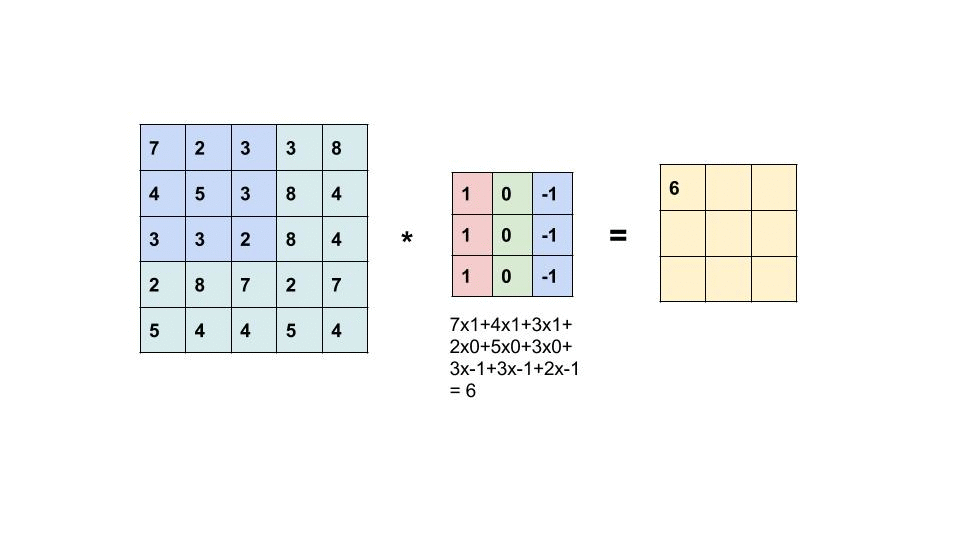

## Rezidualni blok
U tradicionalnim neuronskim mrežama, izlaz iz svakog sloja je ulaz u naredni sloj. U neuronskim mrežama sa ***rezidualnim blokovima***, svaki sloj je istovremeno ulaz u naredni i ulaz u 2.-3. sloj nakon njega. </br>
<br> 



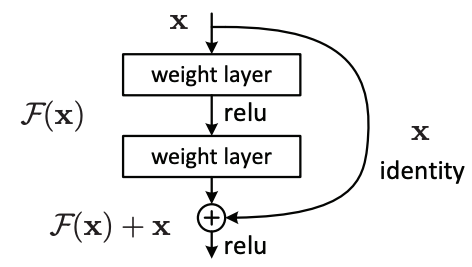
<i><b>Slika 1.</b>Izgled jednog rezidualnog bloka</i>


Neuronske mreže su univerzalni aproksimatori funkcija i njihova tačnost je bolja povećanjem broja slojeva. Medjutim, zbog problema kao sto su "vanishing gradients" ili "the curse of dimensionality", porastom dubine mreže, ona možda neće biti u stanju da nauči jednostavne funkcije poput funkcije identiteta $f(x)=x$.

Povećanjem broja slojeva dolazi do pada tačnosti modela, što predstavlja pretreniranost modela (*koristi se previše kompleksan model, za jednostavan problem iz tog razloga, model vrši lošu generalizaciju na test primerima*). Dolazi se do zaključja da su pliće("shallow") mreže bolje od dubljih mreža, što je suprotno intuitivno. Ovaj problem se naziva **problem degradacije**. 

Jedan od nacina za rešavanje ovog problema je da se preskoči trening nekoliko slojeva koristeći **skip konekcije** ili **rezidualne konekcije**. Moguće je čak i naučiti funkciju identiteta samo zahvaljujući skip konekcijama. Iz tog razloga, se skip konekcije drugačije nazivaju **identitetne prečice**. 

Ako se posmatra neuronsku mreža čiji je ulaz $x$, gde je cilj da neuronska mreža nauči tačnu distribuciju $H(x)$. Razlika izmedju njih(rezidual) je:
$$R(x) = Izlaz - Ulaz = H(x) - x$$
$$ -> H(x) = R(x) + x$$


Na **Slika 1.**, može se primetiti *identity* konekcija koja dolazi od *x*, slojevi izmedju u stvari žele da nauče rezidual, $R(x)$. Slojevi u tradicionalnim neuronskim mrežama žele da nauče pravi izlaz($H(x)$), dok slojevi u rezidualnim mrežama žele da nauce rezidual ($R(x)$). Zbog toga, se zovu **rezidualni blokovi**.

U nastavku se nalazi implementacija rezidualnog bloka koji se koristi u SiGAN mrezi. 

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, strides=(1, 1), kernel_size=(3, 3), activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.kernel_size = kernel_size
        self.activation = activation

        self.conv1 = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation=activation)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation=activation)
        self.bn2 = layers.BatchNormalization()
        self.cnv_skip = layers.Conv2D(filters, (1, 1))
        self.add = layers.Add()
        self.relu = layers.ReLU()
        self.batch_norm = layers.BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x_skip = self.cnv_skip(inputs)
        out = self.add([x_skip, x])
        out = self.relu(out)
        out = self.batch_norm(out)
        return out

## Sijamske mreže (Siamese Network)
Sijamske mreže pripadaju arhitekturi neuronskih mreža koje **sadrže dva ili više identičnih podmreža**. *identične* znači da imaju istu arhitekturu sa istim parametrima i težinama. Parametri se ažuriraju sinhronizovano u obe neuronske mreže. Sijamska mreža se koristi za pronalazak sličnosti izmedju dva ulaza poredeći vektor osobina za svaki ulaz ("*feature vector*").

S obzirom, da trening Sijamskih mreža uključuje obrazovanje parova (*pairwise learning*), ***Cross entropy loss*** funkcija se ne može koristiti za obučavanje ovih neuronskih mreza, vec se koristi jedna od dve loss funkcije:

1. **Triplet loss** je funkcija gubitka gde se početni ulaz poredi sa pozitivnim (tačnim) i negativnim (netačnim) ulazom. Distanca početnog ulaza od tačnog ulaza je minimizovana, a distanca od netačnog ulaza je maksimizovana.
$${\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}^{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}^{2}+\alpha ,0\right)}$$

&emsp; U izrazu iznad, $α$ je faktor margine koji se koristi za "protezanje" razlike udaljenosti izmedju sličnih i razliitih parova u trojcu, $(f(A), f(P), f(N))$, koji predstavljaju vektore osobina(*feature embedding*) za anchor(bazu), pozitivne i negativne slike.

2. **Contrastive loss** je popularna funkcija gubitka, koja se sada često koristi u deep learning-u. Razlikuje se od konvencijonalnih funkcija gubitka jer je bazirana na udaljenosti. Ova funkcija gubitka se koristi za učenje osobina gde dve slične tačke imaju malu Euklidsku distancu, dok dve različite imaju veliku distancu.
$$(1 - Y) \dfrac{1}{2} (D_W)^2+(Y)\dfrac{1}{2} \{max(0, m-D_W)\}^2$$
$$D_W = \sqrt{[G_W(X_1)-G_W(X_2)]^2}$$
<i>gde je $G_W$ izlaz iz mreže za jednu sliku</i>

*Implementacija Contrastive loss-a se nalazi u model.py fajlu 45-50 linija.*

In [ ]:
def contrastive_loss(y, xHR1, xHR2, m=0.5):
    ew = tf.norm(xHR1 - xHR2, axis=-1)
    marginal_loss = 0.5 * tf.square(tf.maximum(0., m - ew))
    generative_loss = 0.5 * tf.square(ew)
    loss = y * generative_loss + (1 - y) * marginal_loss
    return tf.reduce_mean(loss)

## GAN mreže 

Generativna kontradiktorna mreža je okvir za mašinsko učenje koji se sastoji od dve neuronske mreže koje se takmiče u stvaranju preciznijih predvidjanja kao što su slike, jedinstvena muzika, crteži i tako dalje.
<br><br>
One su jedinstvene duboke neuronske mreže sposobne da generišu nove podatke slične onima na kojima se obučavaju. One se takmiče u igri sa nultom sumom koja dovodi do toga da jedan agent gubi igru dok je drugi dobija. 

GAN mreža se sastoji od:
+ **Generatora**: To je konvoluciona neuronska mreža koja veštački proizvodi izlaze slične stvarnim podacima.
+ **Diskriminatora**: To je dekonvoluciona neuronska mreža koja može da identifikuje one izlaze koji su veštački stvoreni.

### SiGAN
#### Uvod
Iako GAN mreže mogu generisati slike visoke rezolucije na osnovu ulaznih slika male rezolucije, one ne mogu garantovati da će identiteti generisanih HR(*high-resolution*) lica biti zadrzani, sto čini HR lica loše prepoznatljivima. Da bi se rešio ovaj problem, napravljen je Siamese GAN(SiGAN) za rekonstrukciju HR lica koja vizuelno podsecaju na njihove odgovarajuće identitete. Na osnovu Sijamske mreže, predloženi SiGAN se sastoji od para identičnih generatora i jednog diskriminatora. <br>
Rezultati eksperimenata pokazuju da SiGAN značajno prevazilazi postojece GAN-ove za generisanje lica sa ciljem verifikacije lica, a istovremeno postižuci fotorealističnu rekonstrukciju. Osim toga, za ulazna LR(low-resolution) lica iz nepoznatih identiteta koji nisu uključeni u trening, SiGAN i dalje može dobro da obavlja posao.

#### Pregled predloženog SiGAN-a
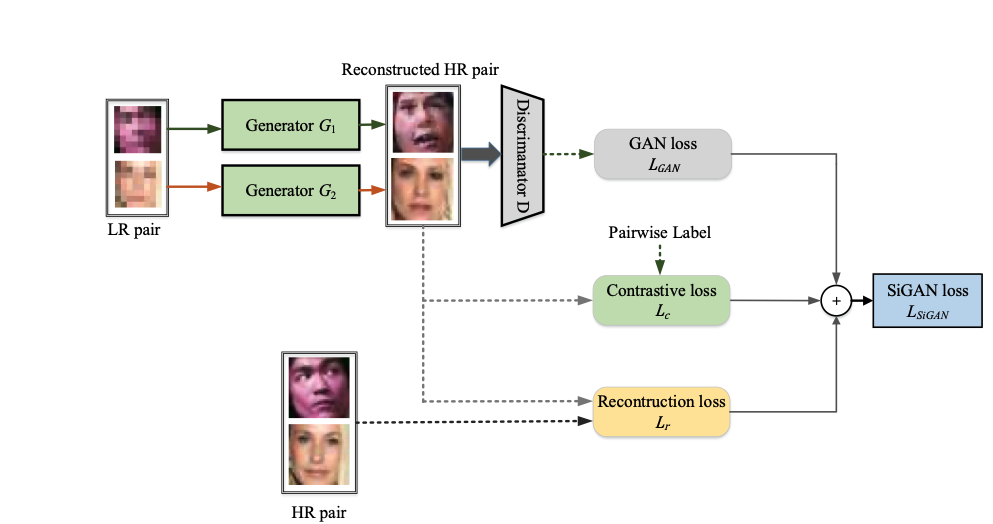

<center><i><b>Slika 2.</b> Arhitektura Siamese GAN (SiGAN) mreže </i></center>

Kako bi se postigla fotorealistična rekonstrukcija koja čuva idenitet, predloženi SiGAN usvaja arhitekturu neuronske mreže sastavljenu od dva generatora koji primaju različiti par ulaza i koji su zatim trenirani na osnovu funkcije cilja. Kako bi se ostvarilo efektivno ucenje, korišćena je ***contrastive loss*** funkcija. Kombinujući *contrastive loss* i *reconstruction loss* u SiGAN treningu, moze se efektivno povećati autentičnost rekonstruisanih slika, dok se očuvava kvalitet slike.


Adversarial loss koji se koristi u GAN mrežama želi da optimizuje sledeći *min-max* problem:
$$min_G\space max_D \space V(D,G)=E_{x∼p_x(x)}[logD(x)] + E_{z∼p_z(z)}[log (1 − D(G(z)))] $$

gde $V$ predstavlja funkciju cilja, $D$ i $G$ predstavljaju generator i diskriminator, respektivno, $G(z)$ je generisani primer od šuma $z$, i $D(x)$ je verovatnoća da je primer $x$ autentifikovan: $D(x)=1$ ako je $x$ identifikovan kao pravi primer; u suprotnom $D(x)=0$. 

***Slika 2.*** prikazuje arhitekuru SiGAN-a, koji je sačinjen od para identičnih *upsampling* generatora $G_1, G_2$ i diskriminatora $D$. U paru generatora, koriste se parovi LR slika kao ulazni podaci, dve slike se porede pomoću *contrastive loss-a ($L_c$)* kako bi se utvrdilo da li te dve slike pokazuju na isti identitet. *Reconstruction loss ($L_r$)*, definiše se kao $L_1$ distanca izmedju prave slike i rekonstruisane HR slike. Diskriminator odlučuje da li je generisana slika stvarna ili lažna bazirano na diskriminator loss funkciji $D(x)$. Tri loss funkcije se sumiraju čineći ukupan loss: $L_{SiGAN}=L_{GAN}+L_c+L_r$. Nakon treninga SiGAN model, koristeći iterativni optimizacioni proces, minimizuje $L_{SiGAN}$ za diskriminator i generatore.

Kako bi se naučile osobine potrebne za ocuvanje identiteta prilikom treniranja SiGAN mreže, dodaje se *contrastive loss* u funkciju cilja. Prvo se **umesto random šuma kao ulaz koristi LR lice $x^{LR}$.** Nakon dodavanja *constrastive loss-a* funkcija cilja izgleda:
$$min_G \space max_D \space V(D, G) = E_D[log \space D(x^{HR}_{1})] + E_G[log \space (1-D(G(x^{LR}_1)))] + E_C[G(x_1^{LR}), G(x_2^{LR})]$$

gde $G(X^{LR})$ je generator korišćen za generisanje HR slika x^{SR}, a $E_C$ je *contrastive loss* definisan:
$$E_C = (1-y)L_I(E_ω(x_1^{SR}, x_2^{SR})) + yL_G(E_ω(x_1^{SR}, x_2^{SR}))$$

Ako računamo $E_ω(x_1^{SR}, x_2^{SR})$ koristeći $l_1 normu$ u domenu piksela (npr. $E_ω=||x_1^{SR} - x_2^{SR}||^1_1$) dobija se loss koji je previše osetljiv na varijacije u pozicijama, osvetljenju, i facijalnim ekspresijama. Stoga, kako bi se dobila otpornija loss funkcija, umesto generisanih slika, koristi se izlaz iz 2. rezidualnog sloja na koji je dodat FC(fully-connected) sloj od 128 neurona koji generiše vektor osobina $P(x^{LR})$ od ulazne $LR$ slike. Iz tog razloga, dobija se $E_ω=||P(x_1^{SR}) - P(x_2^{SR})||^1_1$, $L_I=\dfrac{1}{2}[max(0, m-E_ω)]^2$, $L_G=\dfrac{1}{2}(E_W)^2$, ako je $m=0.5$.

U nastavku se nalazi implementacija *reconstruction loss-a*, *constrastive loss-a* koji se koriste u SiGAN mrezi:


In [ ]:
def reconstruction_loss(original_image, reconstructed_image):
    reconstruction_error = original_image - reconstructed_image
    reconstruction_error = tf.reduce_mean(tf.square(reconstruction_error))
    return reconstruction_error


def get_identity_label(images1, images2):
    images1 = tf.cast(images1, tf.float32)
    images2 = tf.cast(images2, tf.float32)
    return tf.cast(tf.reduce_all(tf.math.equal(images1, images2), axis=(1, 2, 3)), tf.float32)


def contrastive_loss(y, xHR1, xHR2, m=0.5):
    ew = tf.norm(xHR1 - xHR2, axis=-1)
    marginal_loss = 0.5 * tf.square(tf.maximum(0., m - ew))
    generative_loss = 0.5 * tf.square(ew)
    loss = y * generative_loss + (1 - y) * marginal_loss
    return tf.reduce_mean(loss)

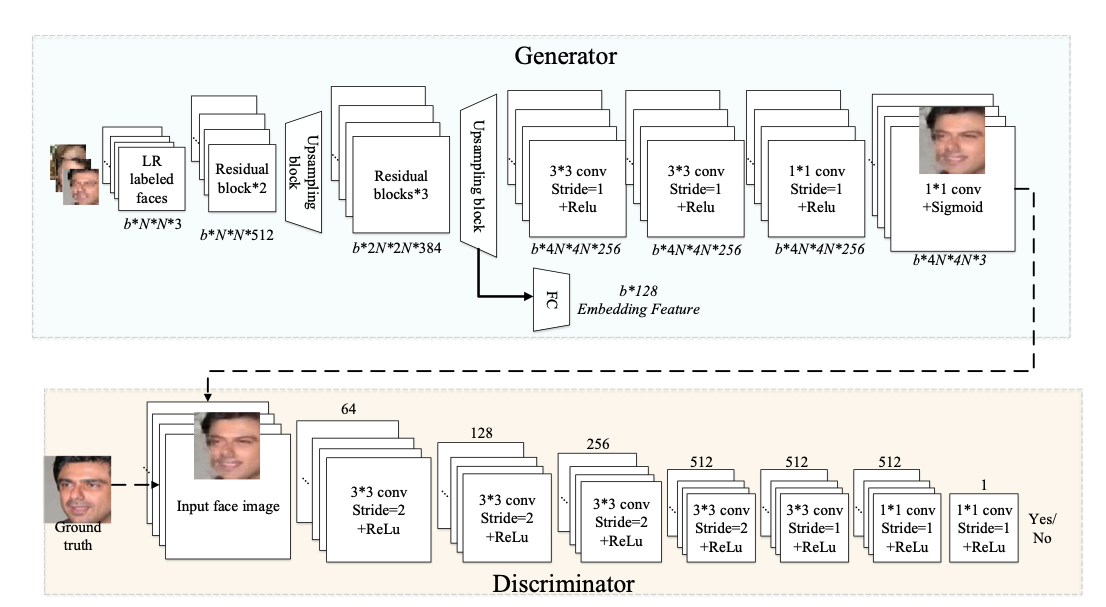
<center><i><b>Slika 3.</b> Pajplajn cele SiGAN mreze, generator(gornji deo), diskriminator(donji deo)</i></center>

#### Generator
Kao što je prikazano u gornjem delu pajplajna, generator je Super-Resolution Convolutional Neural Network (SR CNN). To je mreža koja je dizajnirana da poveća rezoluciju LR slika, čuvajuci originalni sadržaj i detalje. U generatoru, prvo se nalaze 2 rezidualna bloka zbog brže konvergencije i boljih trening performansi. Zatim, ubacuje se *upsampler* sloj izmedju drugog i trećeg sloja da bi povećao rezoluciju ulaza. Treci sloj je praćen sa 3 konvolutivna sloja koji imaju $3x3$ filter, i na kraju je konkatetiran $1x1$ konvolutivni sloj. Kao ulaz nalazi se $NxN$ sliku, a kao izlaz $4Nx4N$. <br> <br>
U nastavku se nalazi implementacija generatora za SiGAN mrezu:

In [ ]:
class Generator(tf.keras.Model):
    def __init__(self, lr_dim=(8, 8, 3)):
        super().__init__()
        self.lr_dim = lr_dim
        self.res_net1 = ResidualBlock(filters=512, kernel_size=(4, 4), strides=(1, 1), input_shape=lr_dim)
        self.res_net2 = ResidualBlock(filters=512, kernel_size=(4, 4), strides=(1, 1))
        self.up1 = layers.UpSampling2D(size=(2, 2))
        self.res_net3 = ResidualBlock(filters=384, kernel_size=(4, 4), strides=(1, 1))
        self.up2 = layers.UpSampling2D(size=(2, 2))
        self.cnv1_layer = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu')
        self.cnv2_layer = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu')
        self.cnv3_layer = Conv2D(filters=256, kernel_size=(1, 1), strides=1, padding='same', activation='relu')
        self.cnv4_layer = Conv2D(filters=3, kernel_size=(1, 1), strides=1, padding='same', activation='sigmoid')
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
        self.fc = Dense(128)
        self.flatten = Flatten()

    def call(self, input_tensor, training=False):
        x = self.res_net1(input_tensor)
        x = self.res_net2(x)
        x = self.up1(x)
        x = self.res_net3(x)
        xc = self.flatten(x)
        xc = self.fc(xc)
        x = self.up2(x)
        x = self.cnv1_layer(x)
        x = self.cnv2_layer(x)
        x = self.cnv3_layer(x)
        x = self.cnv4_layer(x)
        return x, xc

    def loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def summary(self):
        x = tf.keras.Input(shape=(self.lr_dim))
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

#### Diskriminator
Slično diskriminatoru u *DCGAN*, koji je prikazan u donjem pajplajnu ***Slika 3.***, diskriminator je konvolutivna neuronska mreža sastavljena od 7 knvolutivnih slojeva na koje je dodat *average polling* sloj. Izlaz iz diskriminatora je normalizovana vrednost označavajući da li je slika generisana od generatora lažna ili prava. <br> <br>
U nastavku se nalazi implementacija diskriminatora za SiGAN mrežu:

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self, in_shape):
        super().__init__()
        self.in_shape = in_shape
        self.cnv1_layer = Conv2D(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same', input_shape=in_shape)
        self.avg_pooling1 = AveragePooling2D()
        self.cnv2_layer = Conv2D(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same')
        self.cnv3_layer = Conv2D(filters=256, kernel_size=(3, 3), strides=2, activation='relu', padding='same')
        self.cnv4_layer = Conv2D(filters=512, kernel_size=(3, 3), strides=2, activation='relu', padding='same')
        self.cnv5_layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, activation='relu', padding='same')
        self.cnv6_layer = Conv2D(filters=512, kernel_size=(1, 1), strides=1, activation='relu', padding='same')
        self.cnv7_layer = Conv2D(filters=1, kernel_size=(1, 1), strides=1, activation='relu', padding='same')
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

    def call(self, input_tensor, training=False):
        x = self.cnv1_layer(input_tensor)
        x = self.cnv2_layer(x)
        x = self.cnv3_layer(x)
        x = self.cnv4_layer(x)
        x = self.cnv5_layer(x)
        x = self.cnv6_layer(x)
        x = self.cnv7_layer(x)
        return self.avg_pooling1(x)

    def loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def summary(self):
        x = tf.keras.Input(shape=self.in_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

#### Trening modela
Treniramo SiGAN iterativno optimizujući diskriminator, generator, i *contrastive loss* funkcije koristeci *Adam* algoritam.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00001)

U nastavku se nalazi implementacija pomoćnih funkcija za trening SiGAN mreže:

In [ ]:
def low_resolution(images, size=(8, 8)):
    return tf.image.resize(images, size, method='nearest')
    

def plot_images(generator, discriminator, dataset, n=32):
    print("*** Evaluation ***")
    lr_images = low_resolution(next(iter(dataset)))
    x_fake, _ = generator(lr_images)

    x_fake_inv_trans = x_fake.numpy().reshape(-1, 1)
    x_fake_inv_trans = x_fake_inv_trans.reshape(n, 32, 32, 3)

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6), facecolor='white')
    k = 0
    for i in range(0, 2):
        for j in range(0, 3):
            axs[i, j].matshow(x_fake_inv_trans[k])
            k = k + 1
            
    plt.show()


# used to get low-resolution inputs for SiGAN training
def get_LR_images(images, size=(8, 8)):
    return tf.image.resize(images, size, method='nearest')


class SIGAN:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator

    @tf.function
    def train_step(self, images1, images2, batch_size):
        lr_images1 = get_LR_images(images1)
        lr_images2 = get_LR_images(images2)
        identity_label = get_identity_label(images1, images2)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images1, percept_vector1 = self.generator(lr_images1, training=True)
            generated_images2, percept_vector2 = self.generator(lr_images2, training=True)

            fake_logits1 = self.discriminator(generated_images1, training=True)
            fake_logits2 = self.discriminator(generated_images2, training=True)
            real_logits1 = self.discriminator(images1, training=True)
            real_logits2 = self.discriminator(images2, training=True)
            contr_loss = contrastive_loss(identity_label, percept_vector1, percept_vector2)
            generator_loss = self.generator.loss(fake_logits1) + reconstruction_loss(images1, generated_images1) + contr_loss
            generator_loss += self.generator.loss(fake_logits2) + reconstruction_loss(images2, generated_images2)

            discriminator_loss = tf.add(self.discriminator.loss(real_logits1, fake_logits1), self.discriminator.loss(real_logits2, fake_logits2))

        gradients_of_generator = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return discriminator_loss, generator_loss

    def train(self, dataset1, dataset2, n_epochs=1001, n_batch=32, n_eval=10):
        disc_epochs = []
        gen_epochs = []
        for epoch in range(n_epochs):
            epoch_disc_loss = collections.deque(maxlen=100)
            epoch_gen_loss = collections.deque(maxlen=100)

            with tqdm(dataset1) as t:  
                for image_batch1, image_batch2 in zip(t, dataset2):
                    disc_loss, gen_loss = self.train_step(image_batch1, image_batch2, n_batch)
                    epoch_disc_loss.append(disc_loss.numpy())
                    epoch_gen_loss.append(gen_loss.numpy())
                    t.set_postfix(discriminator_loss=np.mean(epoch_disc_loss), generator_loss=np.mean(epoch_gen_loss))

            print("Epoch number: ", epoch)
            print("*** Training ***")
            print("Discriminator Loss ", disc_loss.numpy())
            print("Generator Loss: ", gen_loss.numpy())
            plot_images(self.generator, self.discriminator, dataset1)
            self.save_generator(f'/content/drive/MyDrive/weights/SIGAN/generator/{epoch}/')
            self.save_discriminator(f'/content/drive/MyDrive/weights/SIGAN/discriminator/{epoch}/')
            disc_epochs.append(np.mean(epoch_disc_loss))
            gen_epochs.append(np.mean(epoch_gen_loss))
        
        return disc_epochs, gen_epochs


    def save_generator(self, path):
        self.generator.save_weights(path)

    def save_discriminator(self, path):
        self.discriminator.save_weights(path)

Priprema skupa podataka za treniranje SiGAN mreze i skripta za pokretanje treninga modela:

In [ ]:
ImgLocation = '/content/drive/MyDrive/GAN Project/sample_dataset'

data_lowres1 = keras.preprocessing.image_dataset_from_directory(
    directory=ImgLocation, label_mode=None, image_size=(32, 32), batch_size=32, shuffle=True,
).map(lambda x : x/255.0)
data_lowres2 = keras.preprocessing.image_dataset_from_directory(
    directory=ImgLocation, label_mode=None, image_size=(32, 32), batch_size=32, shuffle=True,
).map(lambda x : x/255.0)

# perform model training 
generator = Generator()
discriminator = Discriminator((32, 32, 3))
gan_model = SIGAN(generator, discriminator)
disc_epochs, gen_epochs = gan_model.train(data_lowres1, data_lowres2, n_epochs=50, n_batch=32, n_eval=5)

Primer treninga:
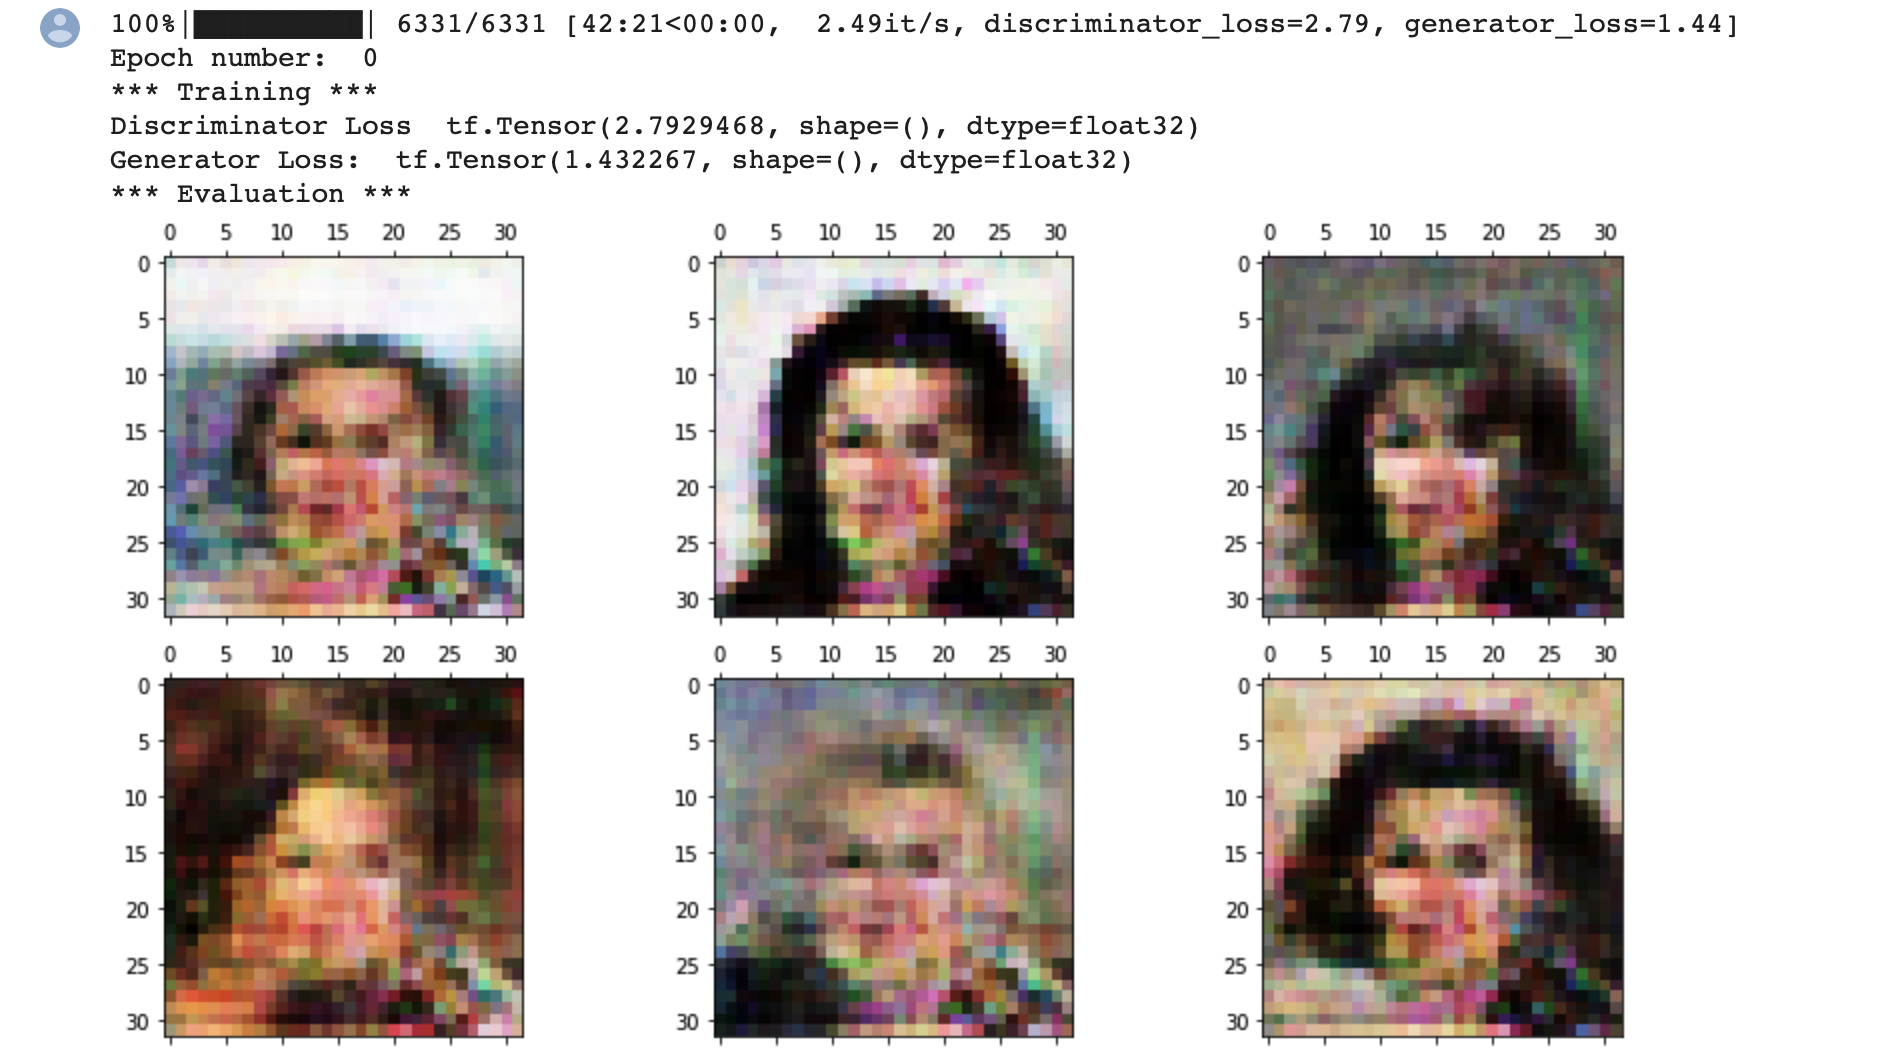


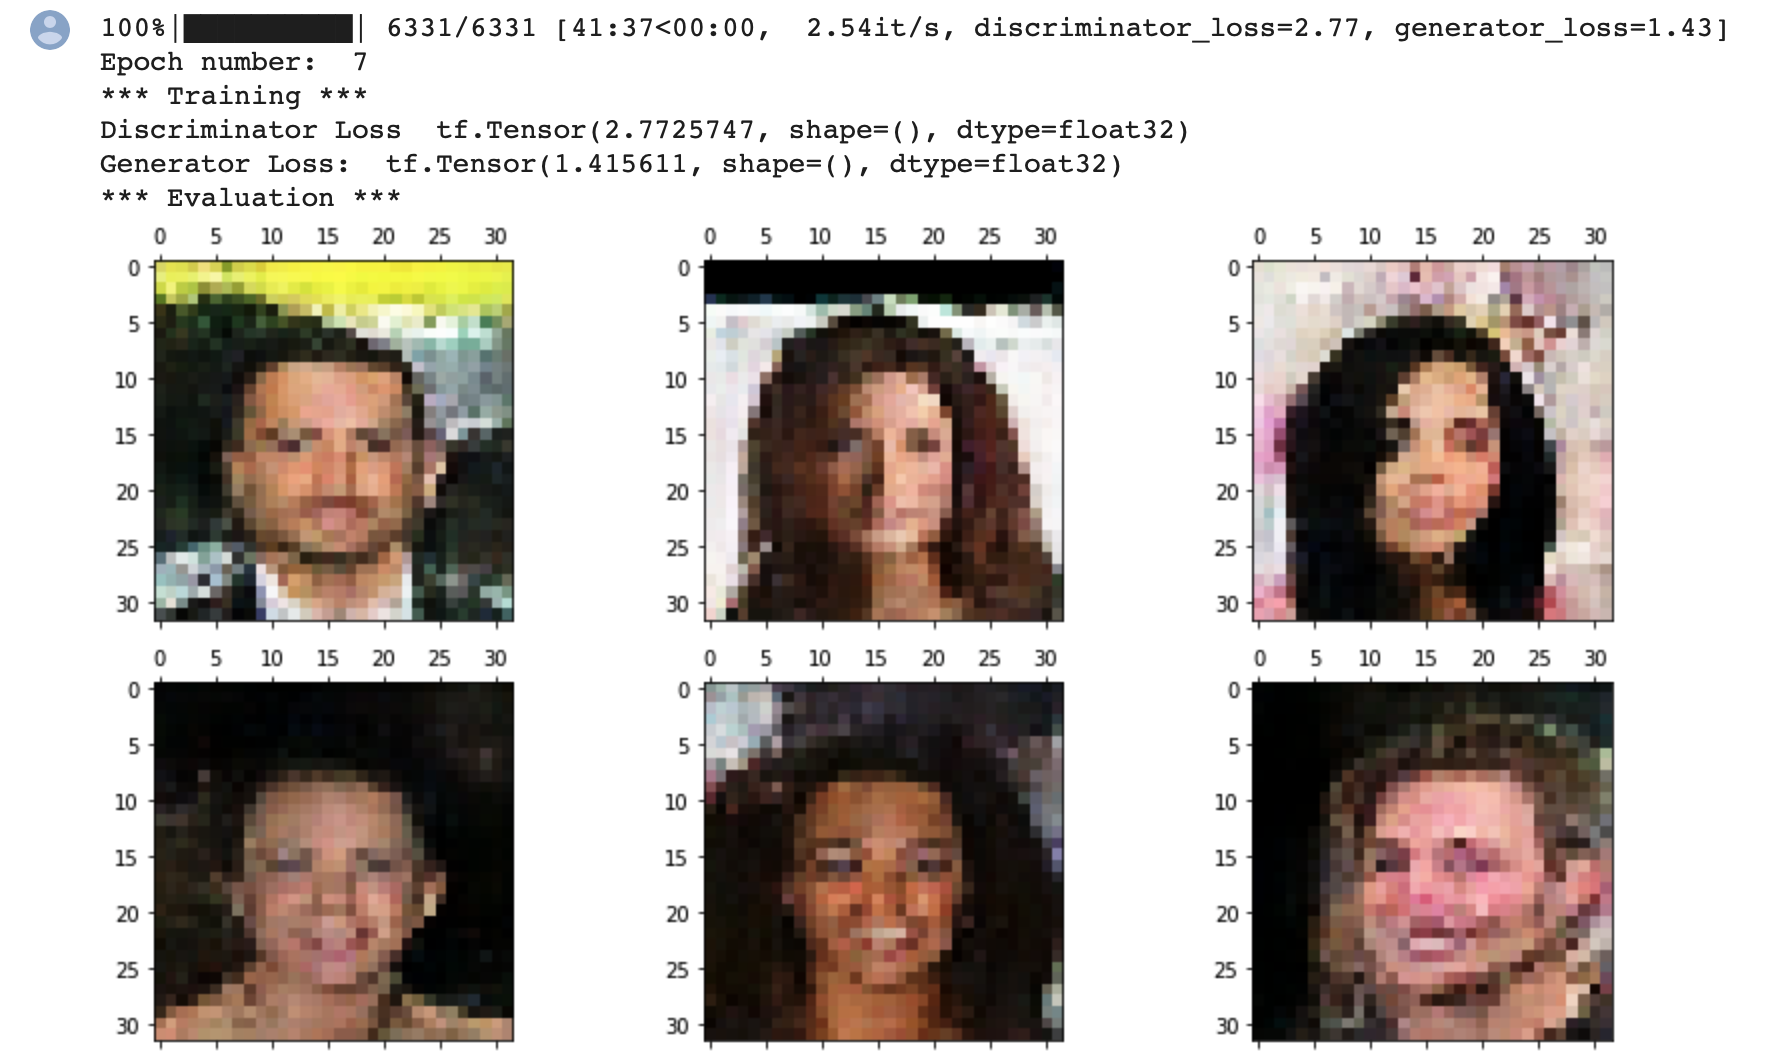

Težine modela je sačuvan po epohama u priloženom direktorijumu `SiGAN-weights`

### DCGAN
#### Uvod
Poslednjih godina nadgledano učenje sa konvolucionim neuronskim mrežama doživelo je ogromno usvajanje u Computer Vision aplikacijama. U poređenju sa nenadgledanim ucenjem, gde se pridaje manje pažnje. U ovom radu se uvodi klasa konvolutivnih neuronskih mreža koje se zovu Deep Convolutional Generative Adversarial Networks (DCGAN). 

#### Pregled predloženog DCGAN-a
Srž ove arhitekture je prihvatanje i modifikacija tri promene u CNN arhitekturi. <br><br>
1. Koriste se **samo konvolutivne mreže** što omogućava mreži da samostalno nauči downsampling/upsampling. Ovaj pristup se koristi u generatoru, omogućavajući mu da nauči sopstveni upsampling, i diskriminatoru.
2. Trend eliminacije fully-connected sloveja na vrhu konvolutivnih mreža. Najbolji primer toga je globalni average polling koji se koristi u state-of-the-art image klasifikacionim modelima. Globalni average polling povećava stabilnost modela ali usporava konvergenciju modela. Kompromis je ostvaren tako što se kao ulaz i izlaz u GAN mreži koristi fully-connected sloj.
3. Batch Normalizacija koja stabilizuje ucenje normalizujući ulaz. Ovaj pristup rešava probleme loše inicijalizacije i lošeg protoga gradijenta u dubljim mrežama. 

Generatorova funkcija gubitka treba da odredi koliko dobro je generator uspeo da prevari diskriminator. Generator je dobar ako diskriminator klasifikuje generisane slike kao prave (labelira ih sa `1`). Kao loss funkcija se koristi binary cross entropy koja poredi diskriminatorovu odluku za generisane slike sa nizom jedinica.
<br><br>

Diskriminatorova funkcija gubitka treba da odredi koliko dobro je diskriminator uspeo da razlikuje pravu sliku od lažnih. Poredi se diskriminatorova predikcija za prave slike sa nizom jedinica i diskriminatorova predikcija za lažne slike sa nizom nula.


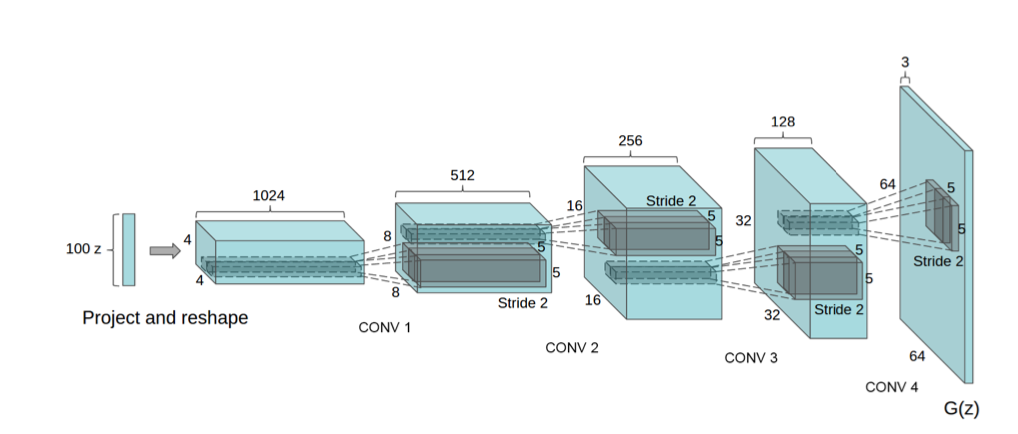
<center><i><b>Slika 4.</b> Izgled DCGAN generatora</i></center>

#### Generator
Generator koristi `Conv2DTranspose`(upsampling) slojeve kako bi proizveo sliku iz šuma. Počinje sa `Dense` slojem koji se nastavlja sa nekoliko upsampling slojeva dok se ne uveća do željene rezolucije. Kao aktivaciona funkcija ce koristi `LeakyReLU` za svaki sloj, osim za izlaz za koji se koristi `tanh`.
<br><br>
U nastavku je prikazana implementacija DCGAN generatora.


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

class Generator(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.n_nodes = 8 * 8 * latent_dim
        self.latent_dim = latent_dim
        self.fc1_layer = Dense(self.n_nodes, input_dim=latent_dim)
        self.reshape_layer = Reshape((8, 8, latent_dim))
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.relu3 = ReLU()
        self.relu4 = ReLU()
        self.batch_norm1 = BatchNormalization()
        self.batch_norm2 = BatchNormalization()
        self.batch_norm3 = BatchNormalization()
        self.batch_norm4 = BatchNormalization()
        self.cnv1_layer = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same')
        self.cnv2_layer = Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same')
        self.cnv3_layer = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same')
        self.cnv4_layer = Conv2D(filters=3, kernel_size=(4,4), activation='sigmoid', padding='same')

    def call(self, input_tensor, training=False):
        x = self.fc1_layer(input_tensor, training=training)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.reshape_layer(x)
        x = self.cnv1_layer(x, training=training)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.cnv2_layer(x, training=training)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.cnv3_layer(x, training=training)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        x = self.cnv4_layer(x, training=training)
        
        return x

    def loss(self, fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

    def summary(self):
      x = tf.keras.Input(shape=(self.latent_dim, ))
      model = tf.keras.Model(inputs=[x], outputs=self.call(x))
      return model.summary()

#### Diskriminator
Diskriminator je standardna CNN mreža sa klasifikaciju slika, u ovom slučaju binarnu.

U nastavku je prikazana implementacija DCGAN diskriminatora.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

class Discriminator(tf.keras.Model):
    def __init__(self, in_shape):
        super().__init__()
        self.in_shape = in_shape
        self.leaky_relu1 = LeakyReLU(alpha=0.2)
        self.leaky_relu2 = LeakyReLU(alpha=0.2)
        self.leaky_relu3 = LeakyReLU(alpha=0.2)
        self.leaky_relu4 = LeakyReLU(alpha=0.2)
        self.drop_out_layer1 = Dropout(0.3)
        self.drop_out_layer2 = Dropout(0.3)
        self.cnv1_layer = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=in_shape)
        self.cnv2_layer = Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=in_shape)
        self.cnv3_layer = Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=in_shape)
        self.cnv4_layer = Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=in_shape)
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, input_tensor, training=False):
        x = self.cnv1_layer(input_tensor, training=training)
        x = self.leaky_relu1(x)
        x = self.cnv2_layer(x, training=training)
        x = self.leaky_relu2(x)
        x = self.drop_out_layer1(x)
        x = self.cnv3_layer(x, training=training)
        x = self.leaky_relu3(x)
        x = self.drop_out_layer2(x)
        x = self.cnv4_layer(x, training=training)
        x = self.leaky_relu4(x)
        x = Flatten()(x)
        x = Dropout(0.2)(x)
        return self.output_layer(x)

    def loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def summary(self):
        x = tf.keras.Input(shape=self.in_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

Optimizacione funkcije koje se koriste za trening modela:

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

#### Trening modela
Model se trenira iterativno, oprimizujući generator i diskriminator.

U nastavku se nalaze pomoćne funkcije za trening DCGAN modela:

In [ ]:
def latent_vector(latent_dim, n):
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input


def fake_samples(generator, latent_dim, n):
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    # Predict outputs (i.e., generate fake samples)
    X = generator(latent_output)
    # Create class labels
    y = np.zeros((n, 1))
    return X, y


def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    print("*** Evaluation ***")

    # Display 6 fake images
    x_fake_inv_trans = x_fake.numpy().reshape(-1, 1)
    x_fake_inv_trans = x_fake_inv_trans.reshape(n, 64, 64, 3)

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6), facecolor='white')
    k = 0
    for i in range(0, 2):
        for j in range(0, 3):
            axs[i, j].matshow(x_fake_inv_trans[k])
            k = k + 1
    plt.show()


class DCGANModel:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator


    @tf.function
    def train_step(self, images, latent_dim, batch_size):
        noise = tf.random.normal([batch_size, latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator.loss(fake_output)
            disc_loss = self.discriminator.loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return disc_loss, gen_loss

    def train(self, dataset, n_epochs=1001, n_batch=32, n_eval=100):
        import collections

        latent_dim = self.generator.latent_dim
        # Our batch to train the discriminator will consist of half real images and half fake (generated) images
        for epoch in range(n_epochs):
            epoch_disc_loss = collections.deque(maxlen=100)
            epoch_gen_loss = collections.deque(maxlen=100)
            with tqdm(dataset) as t:
              for image_batch in t:
                  disc_loss, gen_loss = self.train_step(image_batch, latent_dim, n_batch)
                  epoch_disc_loss.append(disc_loss.numpy())
                  epoch_gen_loss.append(gen_loss.numpy())
                  t.set_postfix(discriminator_loss=np.mean(epoch_disc_loss), generator_loss=np.mean(epoch_gen_loss))
            # Evaluate the model every 100 epochs
            # if epoch % n_eval == 0:
            print("Epoch number: ", epoch)
            print("*** Training ***")
            print("Discriminator Loss ", disc_loss)
            print("Generator Loss: ", gen_loss)
            self.save_generator(f'/content/drive/MyDrive/weights/DCGAN/generator/{epoch}/')
            self.save_discriminator(f'/content/drive/MyDrive/weights/DCGAN/discriminator/{epoch}/')
            performance_summary(self.generator, self.discriminator, dataset, latent_dim)
    
    
    def save_generator(self, path):
        self.generator.save_weights(path)

    def save_discriminator(self, path):
        self.discriminator.save_weights(path)

Priprema skupa podataka za treniranje SiGAN mreze i skripta za pokretanje treninga modela:

In [ ]:
ImgLocation = '/content/img_align_celeba/img_align_celeba'

data_lowres = keras.preprocessing.image_dataset_from_directory(
    directory=ImgLocation, label_mode=None, image_size=(64, 64), batch_size=32, shuffle=True 
).map(lambda x: x / 255.0)


# perform model training 
generator = Generator(128)
discriminator = Discriminator((64, 64, 3))
gan_model = DCGANModel(generator, discriminator)
gan_model.train(data_lowres, n_epochs=20, n_batch=32, n_eval=5)

Primer treninga:

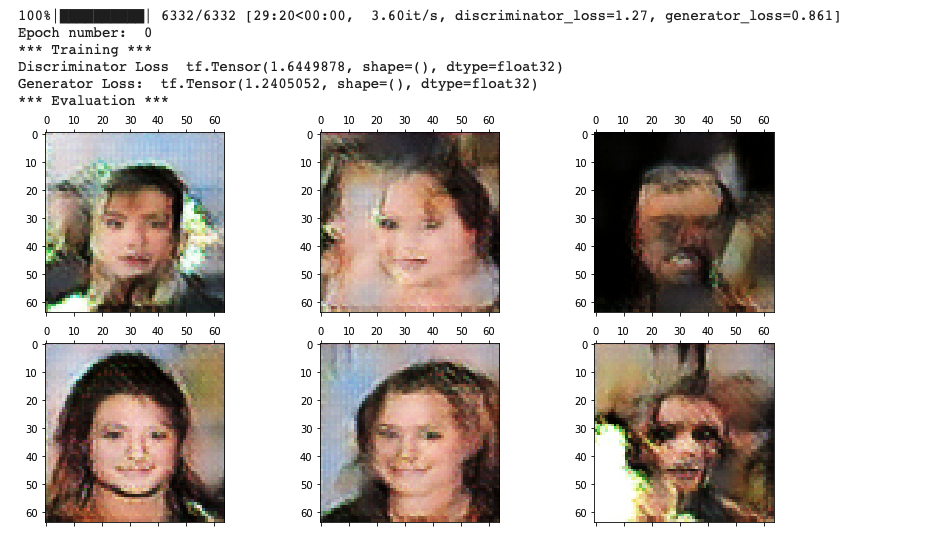

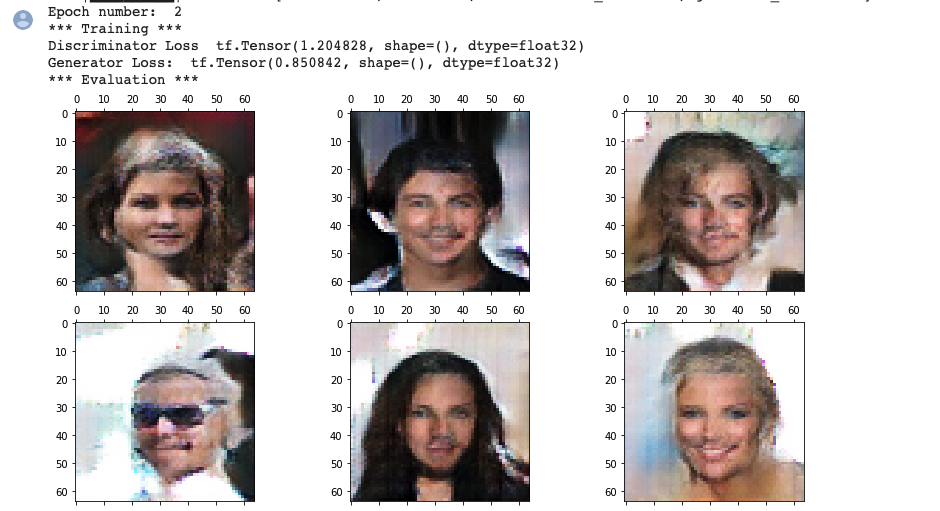

Težine modela je sačuvan po epohama u priloženom direktorijumu `DCGAN-weights`

## Testiranje uspešnosti ekstrakcije lica sa generisanih slika

In [ ]:
def test_extraction(filepath, img_shape=(32, 32)):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_color = img[y:y + h, x:x + w]
        resized = cv2.resize(roi_color, img_shape)
    print(resized.shape)
    return resized

input_image_path = '/content/drive/MyDrive/GAN Project/sample_dataset/043121.jpg'
img = cv2.imread(input_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


### SiGAN test

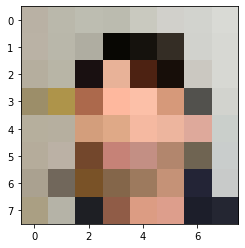

In [ ]:
sigan_generator = Generator()
sigan_generator.built = True
sigan_generator.load_weights('/content/drive/MyDrive/weights (1)/SIGAN/generator/6/')
lr_input_image = low_resolution(img)
plt.imshow(lr_input_image)
plt.show()
cv2.destroyAllWindows()

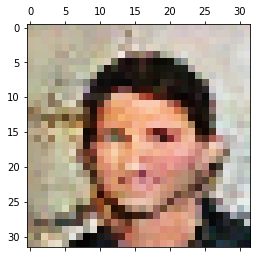

In [ ]:
numpy_img = (tf.cast(lr_input_image, tf.float32).numpy() / 255.0).reshape((-1, 8, 8, 3))
generated_img, _ = sigan_generator(numpy_img)
x_fake_inv_trans = generated_img.numpy().reshape(-1, 1)
x_fake_inv_trans = x_fake_inv_trans.reshape(1, 32, 32, 3)
plt.matshow(x_fake_inv_trans[0])
plt.show()
cv2.destroyAllWindows()

In [ ]:
def extract_face(img):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) * 255.0).astype(np.uint8)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    print("Found {0} Faces!".format(len(faces)))
extract_face(x_fake_inv_trans[0])

Found 0 Faces!


### DCGAN test

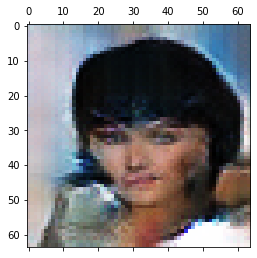

In [ ]:
dcgan_generator = Generator(128)
dcgan_generator.built = True
dcgan_generator.load_weights('/content/drive/MyDrive/weights (1)/DCGAN/generator/2/')
noise = tf.random.normal([1, 128])
generated_img = dcgan_generator(noise)
x_fake_inv_trans = generated_img.numpy().reshape(-1, 1)
x_fake_inv_trans = x_fake_inv_trans.reshape(1, 64, 64, 3)
plt.matshow(x_fake_inv_trans[0])
plt.show()
cv2.destroyAllWindows()

In [ ]:
extract_face(x_fake_inv_trans[0])

Found 0 Faces!



## Zakljucak
Rezultati eksperimenta su pokazali da SiGAN i DCGAN nakon nekoliko epoha ostvare približno realističan prikaz slike. Usled ograničenog broja resursa nije bilo moguće dalje trenirati model. Iz tog razloga, rezultati eksperimenta nisu kvalitetni kao i oni koji su prikazani u naučnom radu. 

